# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#1
# import libraries   
from pyspark import SparkContext        
from pyspark.sql import SparkSession     
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import udf, asc, desc,col, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql import Window, DataFrame
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import MulticlassMetrics
from  pyspark.ml.feature import VectorAssembler,StringIndexer,VectorIndexer,OneHotEncoder, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import  Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, GBTClassifier

import datetime, functools

from matplotlib import pyplot
import seaborn

%matplotlib inline


In [2]:
#2
# create a Spark session
sc = SparkContext()
spark = SparkSession.builder \
      .appName("Capstone") \
       .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#3
event_data= spark.read.json("mini_sparkify_event_data.json")
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
#Looking at how the data is structured. 
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [12]:
#checking the total number of records
event_data.count()

286500

In [14]:
#Checking the existing possible entries for "auth"
event_data.select("auth").distinct().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [5]:
#Checking what the userID column looks like
event_data.select("userID").distinct().sort("userId").show()

+------+
|userID|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



##  There exist records with userIDs that are empty.  They are to be removed.

In [4]:
#4
#Remove records with invalid userID
event_data= event_data.filter("userID != ''")

In [20]:
event_data.select("userID").distinct().sort("userId").show()

+------+
|userID|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [21]:
#Checking to verify that invalid IDs have been removed
event_data.select("sessionID").distinct().sort("sessionId").show()

+---------+
|sessionID|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [22]:
#Verifying that there are no null userIDs
event_data.filter("userID ==null").count()

0

In [23]:
#Verifying that there are no null session IDs
event_data.filter("sessionID == null").count()

0

In [24]:
#Getting a toral count of clean data
event_data.count()

278154

After removing the records with a userID of an empty string  the size of the data set was reducted from 286500 to 278154

In [25]:
event_data.filter("auth == null").count()

0

In [26]:
event_data.filter("ts == null").count()

0

In [28]:
event_data.select("ts").sort("ts").show()

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
|1538353146000|
|1538353150000|
|1538353218000|
|1538353375000|
|1538353376000|
|1538353441000|
|1538353576000|
|1538353668000|
|1538353687000|
|1538353744000|
+-------------+
only showing top 20 rows



In [30]:
event_data.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [31]:
event_data.filter("ts = null").count()

0

In [8]:
event_data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|Next

In [31]:
#Examining the records of a "cancelled" event
event_data.filter("auth == 'Cancelled'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [33]:
#Examine the records of a user who cancels
event_data.filter("userId == 103").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Avril Lavigne|Logged In|    Piper|     F|            0| Nielsen|214.15138| free|New York-Newark-J...|   PUT|   NextSong|1537699856000|      102|               Alice|   200|1538648520000|"Mozilla/5.0 (Mac...|   103|
|                null|Logged In|    Piper|     F|            1| Nielsen|     null| free|New York-Newark-J...

In [36]:
#Checking the nature of the page column
event_data.select("page").distinct().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
#Checking the number of user who cancel
event_data.filter("auth == 'Cancelled'").count()

52

In [17]:
#Checking another way
event_data.filter("page == 'Cancellation Confirmation'").count()

52

It appears that the "Cancellation Confirmation" in the page column is synchronized with the "Cancelled" event in the auth column

In [43]:
#Checking the number of unique locations
event_data.select("Location").distinct().count()

114

In [59]:

event_data.select("userId", "Location").distinct().count()

225

In [60]:
event_data.select("userId").distinct().count()

225

## From the analysis of the userIDs and the Locations, there does not appear to be any change in a user's location from the time that they register

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [5]:
#5
# Create functions to identify churn
downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
cancelled_event = udf(lambda x: 1 if x == "Cancelled" else 0, IntegerType())


In [6]:
#6
# Functions for data manipulation
get_hour  = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
get_day   = udf(lambda x: datetime.date.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_year  = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
get_date  = udf(lambda x: "{:02}".format(datetime.datetime.fromtimestamp(x / 1000.0).month)\
                +"{:02}".format(datetime.date.fromtimestamp(x / 1000.0).day) \
               +"{:02}".format(datetime.date.fromtimestamp(x / 1000.0).year))



In [7]:
#7
get_state = udf(lambda x: x.split()[-1])
get_local = udf(lambda x: x.split()[0])

In [8]:
#8
event_data = event_data.withColumn("downgraded", downgrade_event("page"))\
            .withColumn("cancel", cancelled_event("auth"))\
            .withColumn("day", get_day("ts"))\
            .withColumn("month", get_month("ts"))\
            .withColumn("hour", get_hour("ts"))\
            .withColumn("state", get_state("Location"))\
            .withColumn("locale", get_local("Location"))\
            .withColumn("date", get_date("ts"))\
            .withColumn("year", get_year("ts"))

                        
    

In [38]:
#Checking the available months
event_data.select("month").distinct().show()

+-----+
|month|
+-----+
|   11|
|   10|
|   12|
+-----+



## There are only three months of data represented here

In [39]:
event_data.select("date").take(2)

[Row(date='10012018'), Row(date='10012018')]

In [29]:
event_data.select("day").distinct().count()

31

In [41]:
event_data.groupBy("userId","month" ).sum("length").show()

+------+-----+------------------+
|userId|month|       sum(length)|
+------+-----+------------------+
|     5|   10|       25923.71308|
|   148|   10| 69699.65937000002|
|200015|   11| 5853.062469999999|
|200014|   10|45779.845239999995|
|    42|   11|489245.64023999916|
|   122|   10| 9482.116939999998|
|200002|   10| 64662.97118999998|
|200025|   10|       70270.82628|
|    20|   10| 296682.1260800004|
|   126|   10|355429.15804999974|
|   152|   11| 352544.0705899998|
|   123|   10|        4471.94523|
|100013|   10|269031.42266999994|
|200018|   10| 79034.26837000002|
|300007|   10| 28028.71048000002|
|    51|   10| 523275.8428000004|
|    61|   11|163958.97727000003|
|300005|   11|         8634.4709|
|   101|   10| 447464.0146699989|
|   152|   12|         297.01179|
+------+-----+------------------+
only showing top 20 rows



In [41]:
event_data.select("state").distinct().collect()

[Row(state='UT-ID'),
 Row(state='AZ'),
 Row(state='SC'),
 Row(state='GA-AL'),
 Row(state='LA'),
 Row(state='RI-MA'),
 Row(state='NJ'),
 Row(state='IL-MO'),
 Row(state='MN-WI'),
 Row(state='OR'),
 Row(state='SC-NC'),
 Row(state='PA-NJ'),
 Row(state='MD-WV'),
 Row(state='VA'),
 Row(state='NY-NJ-PA'),
 Row(state='KY'),
 Row(state='NH'),
 Row(state='MI'),
 Row(state='NV'),
 Row(state='WI'),
 Row(state='CA'),
 Row(state='CT'),
 Row(state='MT'),
 Row(state='NC'),
 Row(state='MD'),
 Row(state='NE-IA'),
 Row(state='IL'),
 Row(state='WA'),
 Row(state='MS'),
 Row(state='AL'),
 Row(state='IN'),
 Row(state='OH'),
 Row(state='TN'),
 Row(state='IA'),
 Row(state='PA'),
 Row(state='DC-VA-MD-WV'),
 Row(state='NY'),
 Row(state='MO-KS'),
 Row(state='KY-IN'),
 Row(state='PA-NJ-DE-MD'),
 Row(state='TX'),
 Row(state='WV'),
 Row(state='VA-NC'),
 Row(state='OR-WA'),
 Row(state='GA'),
 Row(state='IL-IN-WI'),
 Row(state='OH-KY-IN'),
 Row(state='MO-IL'),
 Row(state='FL'),
 Row(state='CO'),
 Row(state='AK'),
 Row

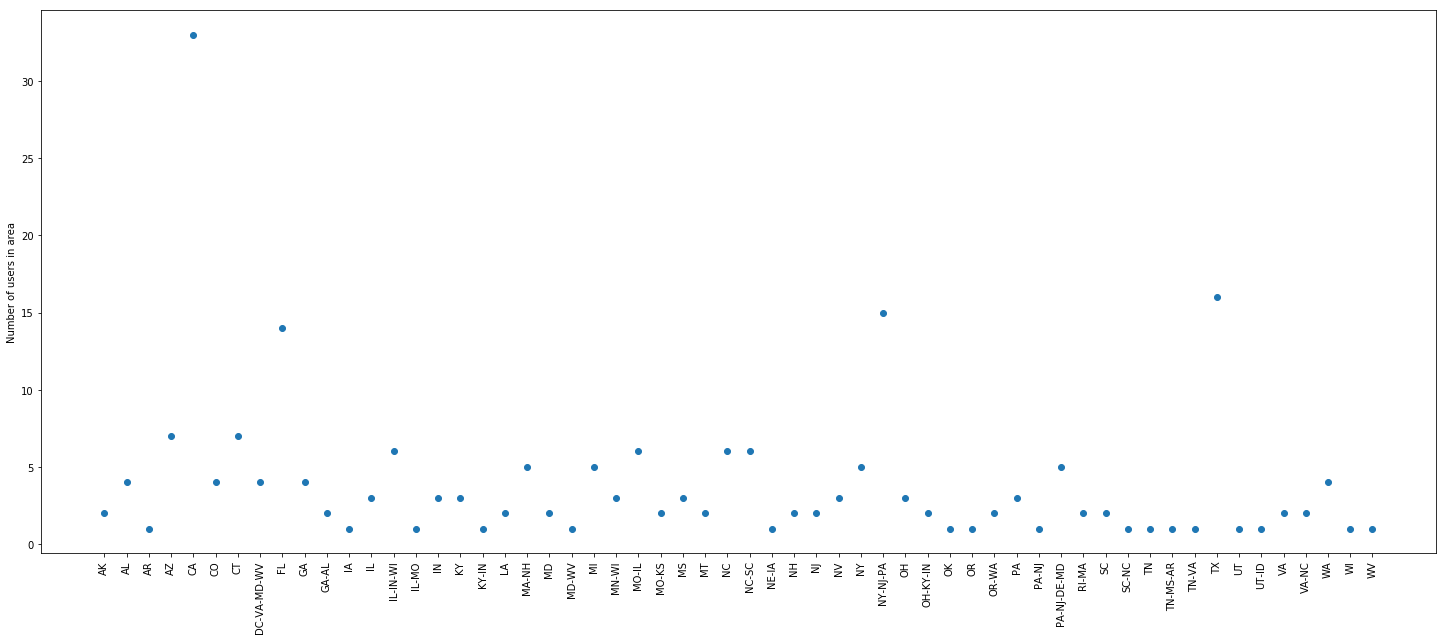

In [33]:
state = event_data.select(["userID", "state"]).distinct().groupBy("state").count()
state= state.toPandas()
pyplot.figure(figsize=(25,10))
pyplot.scatter(state["state"], state["count"])
pyplot.ylabel("Number of users in area")
pyplot.xticks(rotation = 'vertical');



In [25]:
event_data.select("state").distinct().count()

58

In [46]:
event_data.groupBy("userId").sum("cancel").describe().show()

+-------+------------------+------------------+
|summary|            userId|       sum(cancel)|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [47]:
event_data.groupBy("userId").sum("downgraded").describe().show()

+-------+------------------+------------------+
|summary|            userId|    sum(downgrade)|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|              0.28|
| stddev|105396.47791907164|0.5876709477736184|
|    min|                10|                 0|
|    max|                99|                 3|
+-------+------------------+------------------+



In [51]:
event_data.groupBy("userId").sum("downgraded").filter("sum(downgrade) >0").sort(desc("sum(downgrade)")).show()

+------+--------------+
|userId|sum(downgrade)|
+------+--------------+
|   140|             3|
|    39|             3|
|    35|             2|
|    20|             2|
|    85|             2|
|    61|             2|
|   131|             2|
|200003|             2|
|200023|             2|
|    13|             2|
|100004|             2|
|100018|             2|
|    77|             1|
|300002|             1|
|    30|             1|
|100009|             1|
|    96|             1|
|100008|             1|
|300011|             1|
|   100|             1|
+------+--------------+
only showing top 20 rows



In [53]:
#Checking the records of someone who has downgraded multiple times
event_data.filter("userId == 140").sort("ts").collect()

[Row(artist=None, auth='Logged In', firstName='Lucero', gender='F', itemInSession=0, lastName='Reed', length=None, level='free', location='Louisville/Jefferson County, KY-IN', method='GET', page='Home', registration=1536642109000, sessionId=139, song=None, status=200, ts=1538406127000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='140', downgrade=0, cancel=0, day='1', month='10', hour='15', state='KY-IN', locale='Louisville/Jefferson', year='2018'),
 Row(artist='Insane Clown Posse / Mike E Clark', auth='Logged In', firstName='Lucero', gender='F', itemInSession=1, lastName='Reed', length=272.45669, level='free', location='Louisville/Jefferson County, KY-IN', method='PUT', page='NextSong', registration=1536642109000, sessionId=139, song='Cherry Pie (I Need A Freak)', status=200, ts=1538406157000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125

So a user can downgrade more than once. 

In [11]:
#9
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [12]:
#10
event_data = event_data.withColumn("phase", Fsum("downgraded").over(windowval))

In [19]:
event_data.select(["userId", "ts", "month", "day", "hour", "page", "auth", "phase", "downgraded"]).filter("userId ==140").filter("downgraded==1").show()

+------+-------------+-----+---+----+----------------+---------+-----+----------+
|userId|           ts|month|day|hour|            page|     auth|phase|downgraded|
+------+-------------+-----+---+----+----------------+---------+-----+----------+
|   140|1539337383000|   10| 12|   9|Submit Downgrade|Logged In|    1|         1|
|   140|1541523845000|   11|  6|  17|Submit Downgrade|Logged In|    2|         1|
|   140|1542290890000|   11| 15|  14|Submit Downgrade|Logged In|    3|         1|
+------+-------------+-----+---+----+----------------+---------+-----+----------+



In [ ]:
1538406127000

In [59]:
event_data.take(6)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', downgrade=0, cancel=0, day='1', month='10', hour='0', state='CA', locale='Bakersfield,'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', downgrade=0, cancel=0, day='1', month='10', hour='0', state='MA-NH',

In [13]:
event_data.filter("userId == 140").sort("ts").collect()

[Row(artist=None, auth='Logged In', firstName='Lucero', gender='F', itemInSession=0, lastName='Reed', length=None, level='free', location='Louisville/Jefferson County, KY-IN', method='GET', page='Home', registration=1536642109000, sessionId=139, song=None, status=200, ts=1538406127000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='140', downgraded=0, cancel=0, day='1', month='10', hour='15', state='KY-IN', locale='Louisville/Jefferson', year='2018', phase=3),
 Row(artist='Insane Clown Posse / Mike E Clark', auth='Logged In', firstName='Lucero', gender='F', itemInSession=1, lastName='Reed', length=272.45669, level='free', location='Louisville/Jefferson County, KY-IN', method='PUT', page='NextSong', registration=1536642109000, sessionId=139, song='Cherry Pie (I Need A Freak)', status=200, ts=1538406157000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.

In [9]:
#11  Feature engineering to find the number of Months accessed in a month
monthly_count =event_data.filter("page == 'NextSong'").groupBy("userId","month" ).count().sort("userId")
monthly_count.show()

+------+-----+-----+
|userId|month|count|
+------+-----+-----+
|    10|   10|  459|
|    10|   11|  214|
|   100|   10| 1216|
|   100|   11| 1466|
|100001|   10|  133|
|100002|   12|    1|
|100002|   11|  191|
|100002|   10|    3|
|100003|   10|   51|
|100004|   10|  413|
|100004|   11|  529|
|100005|   10|  154|
|100006|   10|   26|
|100007|   11|  201|
|100007|   10|  222|
|100008|   11|  525|
|100008|   10|  247|
|100009|   10|  518|
|100010|   11|  155|
|100010|   10|  120|
+------+-----+-----+
only showing top 20 rows



In [10]:
#12 Create the feature of average songs accessed per month
average_songs_per_month = monthly_count.groupBy("userId" ).agg(avg("count").alias("avg_song_month"))


average_songs_per_month.show()

+------+--------------+
|userId|avg_song_month|
+------+--------------+
|    10|         336.5|
|   100|        1341.0|
|100001|         133.0|
|100002|          65.0|
|100003|          51.0|
|100004|         471.0|
|100005|         154.0|
|100006|          26.0|
|100007|         211.5|
|100008|         386.0|
|100009|         518.0|
|100010|         137.5|
|100011|          11.0|
|100012|         238.0|
|100013|         565.5|
|100014|         128.5|
|100015|         400.0|
|100016|         265.0|
|100017|          52.0|
|100018|         501.0|
+------+--------------+
only showing top 20 rows



In [11]:
#13  Feature engineering to create a feature of average time the service is used per day
daily_time=event_data.filter("page == 'NextSong'").groupBy("userId","date" )\
                            .agg(Fsum("length").alias("day_length")).sort("userId")


average_time_per_day = daily_time.select(["userID", "day_length"]).groupBy("userId" )\
                            .agg(avg("day_length").alias("ave_time_day"))
average_time_per_day.show()

+------+------------------+
|userId|      ave_time_day|
+------+------------------+
|    10|20858.296563749995|
|   100|20390.238078484854|
|100001|17536.871075000003|
|100002| 9911.983620000003|
|100003| 6153.209660000001|
|100004|12183.178383684213|
|100005| 9259.280502500002|
|100006|        5854.89105|
|100007| 11610.59165777778|
|100008| 23924.59950250001|
|100009|      12974.578968|
|100010| 9562.985335714286|
|100011|         2841.6995|
|100012| 16500.47901571428|
|100013|20027.985293571433|
|100014|11283.912013333334|
|100015|12974.527769999999|
|100016|12937.675234000002|
|100017|12261.723399999999|
|100018|13080.543559473683|
+------+------------------+
only showing top 20 rows



In [12]:
#14   Feature engineering to view total time used listening per month
monthly_time=event_data.filter("page == 'NextSong'").groupBy("userId","month" )\
                            .agg(Fsum("length").alias("month_length")).sort("userId")


average_time_per_month = monthly_time.select(["userID", "month_length"]).groupBy("userId" )\
                            .agg(avg("month_length").alias("ave_time_month"))
average_time_per_month.show()

+------+------------------+
|userId|    ave_time_month|
+------+------------------+
|    10| 83433.18625500001|
|   100| 336438.9282949999|
|100001|35073.742150000005|
|100002|16519.972700000002|
|100003|12306.419320000003|
|100004|115740.19464500001|
|100005| 37037.12201000001|
|100006|        5854.89105|
|100007| 52247.66246000002|
|100008|       95698.39801|
|100009|129745.78967999991|
|100010|      33470.448675|
|100011|         2841.6995|
|100012|57751.676555000005|
|100013|140195.89705499998|
|100014|       33851.73604|
|100015| 97308.95827500003|
|100016|       64688.37617|
|100017|12261.723399999999|
|100018|124265.16381499998|
+------+------------------+
only showing top 20 rows



In [13]:
#15  Feature engineering to access the average number of songs accessed per day
daily_count =event_data.filter("page == 'NextSong'").groupBy("userId","date").count().sort("userId")
average_songs_per_day = daily_count.groupBy("userId" ).agg(avg("count").alias("avg_time_day"))
average_songs_per_day.show()

+------+------------------+
|userId|      avg_time_day|
+------+------------------+
|    10|            84.125|
|   100| 81.27272727272727|
|100001|              66.5|
|100002|              39.0|
|100003|              25.5|
|100004|49.578947368421055|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|              96.5|
|100009|              51.8|
|100010|39.285714285714285|
|100011|              11.0|
|100012|              68.0|
|100013| 80.78571428571429|
|100014|42.833333333333336|
|100015|53.333333333333336|
|100016|              53.0|
|100017|              52.0|
|100018| 52.73684210526316|
+------+------------------+
only showing top 20 rows



In [14]:
#16   Feature engineering to determine if a user cancels their subscription,  
# The column "label"  is necessary for the later Vectorization
churned = event_data.groupBy(["userId","state"]).agg(Fsum("cancel").alias("label"))
churned.show()

+------+--------+-----+
|userId|   state|label|
+------+--------+-----+
|    92|   MA-NH|    0|
|    73|      NY|    1|
|200004|      NC|    0|
|300020|      GA|    0|
|   121|      CA|    1|
|100017|      AL|    1|
|200022|   MO-IL|    0|
|300010|      TX|    0|
|    51|      KY|    1|
|   137|NY-NJ-PA|    0|
|    97|      CA|    0|
|    96|      NJ|    0|
|100018|      TX|    0|
|   122|TN-MS-AR|    1|
|    34|      FL|    0|
|    45|      GA|    0|
|    33|      CT|    0|
|    94|   NE-IA|    0|
|    42|      VA|    0|
|100021|      TX|    1|
+------+--------+-----+
only showing top 20 rows



In [15]:
# 17
# All engineered features are combined into a final dataset

final_data = churned.join(average_songs_per_day, on=["userId"])\
                    .join(average_songs_per_month, on=["userId"])\
                    .join(average_time_per_day, on=["userId"])\
                    .join(average_time_per_month, on=["userId"])
                    
final_data.show(5)

+------+--------+-----+------------------+--------------+------------------+------------------+
|userId|   state|label|      avg_time_day|avg_song_month|      ave_time_day|    ave_time_month|
+------+--------+-----+------------------+--------------+------------------+------------------+
|100010|      CT|    0|39.285714285714285|         137.5| 9562.985335714286|      33470.448675|
|200002|IL-IN-WI|    0|55.285714285714285|         193.5|13429.839419999995|47004.437969999984|
|   125|      TX|    1|               8.0|           8.0|2089.1131000000005|2089.1131000000005|
|   124|      NJ|    0|         127.46875|        2039.5|31634.752899687504| 506156.0463950002|
|    51|      KY|    1| 162.3846153846154|        2111.0| 40251.98790769231| 523275.8428000004|
+------+--------+-----+------------------+--------------+------------------+------------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [16]:
#18   Creating a pipeline to concatenate models. 
stage_list =[]
 #Convert the categorical columns into numerical features
stage_list.append( StringIndexer(handleInvalid="keep").setInputCol("state").setOutputCol("stateIndex"))
#Covert these numberal features and covert to Dummy Variables
stage_list.append( OneHotEncoder().setInputCol("stateIndex").setOutputCol("stateVector"))

#Create a vectors for the Numerical Features
stage_list.append( VectorAssembler()\
                  .setInputCols(["avg_time_day","avg_song_month","ave_time_day","ave_time_month"])\
                  .setOutputCol("NumFeatures") )
#Normalize the Numerical Features
stage_list.append( Normalizer().setInputCol("NumFeatures").setOutputCol("NormalizedFeatures"))
#Create a Vector of the features
stage_list.append( VectorAssembler()\
                   .setInputCols(["stateVector","NormalizedFeatures"])\
                    .setOutputCol("features"))
#Final pipeline snub
pipeline = Pipeline(stages=stage_list)


Although the TrainValidationSplit object creates its own validation set, because we are testing several approaches, we are holding back a portion of the test set to make a final evaluation.

In [17]:
#19
#Create the training and test set.
training , test = final_data.randomSplit([0.7, .3], seed=101)
#Save a portion of the test set to  be used for the final evaluation
model_test, final_test = test.randomSplit([.5,.5], seed=101)

In [25]:
#20
#Create a Logistic Regression and investigate the tuneable paramters
lr = LogisticRegression()

print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [26]:
#21   Create a parameter grid for the Logistic Regression model
lr_paramGrid = ParamGridBuilder().addGrid(lr.aggregationDepth, [2,4,6])\
                                 .addGrid(lr.maxIter, [20,100])\
                                 .build()
                                    


## Although we are using a binary classification, the BinaryClassiciationEvaluator has no option for F1

##F1 score is the default for the MulticlassClassificationEvaluator

In [29]:
#22
lr_multi_train = TrainValidationSplit(estimator=Pipeline(stages=[pipeline,lr]),\
                                estimatorParamMaps=lr_paramGrid,\
                                evaluator=MulticlassClassificationEvaluator() #F1 score is the default
                                )

In [25]:
#Produce a function to train and evaluate different pipelines

def process_models(training_pipeline, training_set , test_set):
    #Fit the pipeline and set the model
    model = training_pipeline.fit(training_set )
    #Get the predictions
    results = model.transform(test_set)
    #Grade the predictions
    correct = results.filter(results.prediction == results.label).count()
    #print results 
    
    print("The number of correct predictions is {} out of {}"\
          .format(correct, results.count()))
    print("The model validation metrics are \n{}".format(model.validationMetrics))
    metrics = MulticlassMetrics(results.select([col(c).cast("double") for c in ["prediction", "label"]]).rdd)
    print("The accuracy of the model is {}".format(metrics.accuracy))
    cm = metrics.confusionMatrix()
   
                                    
    
    print("The Confusion Matrix is:")
    print(cm)
    
    
    
    return model
    
    
    

In [21]:
#25
#Create Naive Bayes Model and examine tubeable parameters

nb = NaiveBayes()

print(nb.explainParams())

featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
modelType: The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli. (default: multinomial)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is 

In [32]:
#26  Create Parameter Grid
nb_ParamGrid = ParamGridBuilder().addGrid(nb.smoothing, [0,.1,.3,.5,.7,.9, 1.0])\
                                .build()

In [33]:
#27 Establish pipeline for Naive Bayes.
nb_multi_train = TrainValidationSplit(estimator=Pipeline(stages=[pipeline, nb]), \
                                estimatorParamMaps=nb_ParamGrid,\
                                evaluator=MulticlassClassificationEvaluator()
                                )

In [34]:
#Create a RandomForestClassifier and examine tuneable parameters.

rf = RandomForestClassifier()
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [35]:
# Create a parameter Grid for Random Forest
rf_paramGrid = ParamGridBuilder().addGrid(rf.maxBins, [16,32, 64])\
                                 .addGrid(rf.maxDepth, [3,5,7])\
                                 .addGrid(rf.numTrees, [10,20,30])\
                                 .build()

In [36]:
# Set up Random Forest Pipeline
rf_multi_train = TrainValidationSplit(estimator=Pipeline(stages=[pipeline, rf]), \
                                estimatorParamMaps=rf_paramGrid,\
                                evaluator=MulticlassClassificationEvaluator()
                                )

In [37]:
#Create a Gradiant Boost Classifier and examine the tuneable parameters
gbt = GBTClassifier()

print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [38]:
# Set up a parameter grid for Gradient booste
gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxBins, [16,32])\
                                 .addGrid(gbt.maxDepth, [3,5,7])\
                                 .addGrid(gbt.stepSize, [.05, .1])\
                                 .build()

In [39]:
#
gbt_multi_train = TrainValidationSplit(estimator=Pipeline(stages=[pipeline,gbt]), \
                                estimatorParamMaps=gbt_paramGrid,\
                                evaluator=MulticlassClassificationEvaluator()
                                )

### Compare the various model candidates. 

In [43]:
logistic_regression_model = process_models(lr_multi_train, training, model_test)

The number of correct predictions is 13 out of 19
The model validation metrics are 
[0.6362007168458783, 0.671875, 0.6362007168458783, 0.671875, 0.6362007168458783, 0.671875]
The accuracy of the model is 0.6842105263157895
The Confusion Matrix is:
DenseMatrix([[ 12.,   4.],
             [  2.,   1.]])


In [44]:
nb_model  = process_models(nb_multi_train, training, model_test)

The number of correct predictions is 17 out of 19
The model validation metrics are 
[0.6881720430107527, 0.6171875, 0.6653272101033294, 0.6653272101033294, 0.6813725490196079, 0.6976284584980237, 0.6428571428571428]
The accuracy of the model is 0.8947368421052632
The Confusion Matrix is:
DenseMatrix([[ 16.,   0.],
             [  2.,   1.]])


In [45]:
random_forest_model = process_models(rf_multi_train, training, model_test)

The number of correct predictions is 16 out of 19
The model validation metrics are 
[0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6304347826086956, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6428571428571428, 0.6304347826086956, 0.6428571428571428]
The accuracy of the model is 0.8421052631578947
The Confusion Matrix is:
DenseMatrix([[ 16.,   0.],
             [  3.,   0.]])


In [46]:
gradient_boosting_model = process_models(gbt_multi_train, training, model_test)

The number of correct predictions is 9 out of 19
The model validation metrics are 
[0.6493506493506493, 0.6333333333333333, 0.6333333333333333, 0.6171875, 0.6171875, 0.6171875, 0.6493506493506493, 0.6493506493506493, 0.6493506493506493, 0.671875, 0.6333333333333333, 0.6333333333333333]
The accuracy of the model is 0.47368421052631576
The Confusion Matrix is:
DenseMatrix([[ 9.,  7.],
             [ 3.,  0.]])


In [48]:
 #Taking the naive bayes model as the final model



results = nb_model.transform(final_test)
correct = results.filter(results.prediction == results.label).count()

print("The number of correct predictions is {} out of {}"\
      .format(correct, results.count()))

metrics = MulticlassMetrics(results.select([col(c).cast("double") for c in ["prediction", "label"]]).rdd)
print("The accuracy of the model is {}".format(metrics.accuracy))
print(metrics.confusionMatrix())


The number of correct predictions is 32 out of 50
The accuracy of the model is 0.64
DenseMatrix([[ 32.,   5.],
             [ 13.,   0.]])


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [26]:
#Attempt to refine the model by increasing the parameter grid

nb_ParamGrid = ParamGridBuilder().addGrid(nb.smoothing, [0,.05,.1,.2,.3,.35, .4,.5,.6,.65, .7,.8,.9,.95, 1.0])\
                                .build()

nb_multi_train = TrainValidationSplit(estimator=Pipeline(stages=[pipeline, nb]), \
                                estimatorParamMaps=nb_ParamGrid,\
                                evaluator=MulticlassClassificationEvaluator()
                                )
refined_nb_model  = process_models(nb_multi_train, training, model_test)

The number of correct predictions is 17 out of 19
The model validation metrics are 
[0.7430340557275542, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751, 0.7699248120300751]
The accuracy of the model is 0.8947368421052632
The Confusion Matrix is:
DenseMatrix([[ 16.,   0.],
             [  2.,   1.]])


In [29]:
type(refined_nb_model)

pyspark.ml.tuning.TrainValidationSplitModel

In [30]:
#This violates the rule of re-using test data
results = refined_nb_model.transform(final_test)
correct = results.filter(results.prediction == results.label).count()

print("The number of correct predictions is {} out of {}"\
      .format(correct, results.count()))

metrics = MulticlassMetrics(results.select([col(c).cast("double") for c in ["prediction", "label"]]).rdd)
print("The accuracy of the model is {}".format(metrics.accuracy))
print(metrics.confusionMatrix())


The number of correct predictions is 32 out of 50
The accuracy of the model is 0.64
DenseMatrix([[ 32.,   5.],
             [ 13.,   0.]])
